In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
root_path = '/content/gdrive/My Drive/'

In [0]:
import os
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

%matplotlib inline
print(os.listdir("/content/gdrive/My Drive/Turkey/dont-call-me-turkey"))
warnings.filterwarnings('ignore')

['sample_submission.csv', 'test.json', 'train.json']


In [0]:
train  = pd.read_json('/content/gdrive/My Drive/Turkey/dont-call-me-turkey/train.json')
test   = pd.read_json('/content/gdrive/My Drive/Turkey/dont-call-me-turkey/test.json')
sample = pd.read_csv('/content/gdrive/My Drive/Turkey/dont-call-me-turkey/sample_submission.csv')

In [0]:
train.shape

(1195, 5)

In [0]:
test.shape

(1196, 4)

In [0]:
sample.shape 

(1196, 2)

In [0]:
train.head()

,audio_embedding,is_turkey,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",0,kDCk3hLIVXo,70,60
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",1,DPcGzqHoo7Y,40,30
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",1,7yM63MTHh5k,240,230
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",1,luG3RmUAxxM,520,510
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",0,PIm3cjxTpOk,10,0


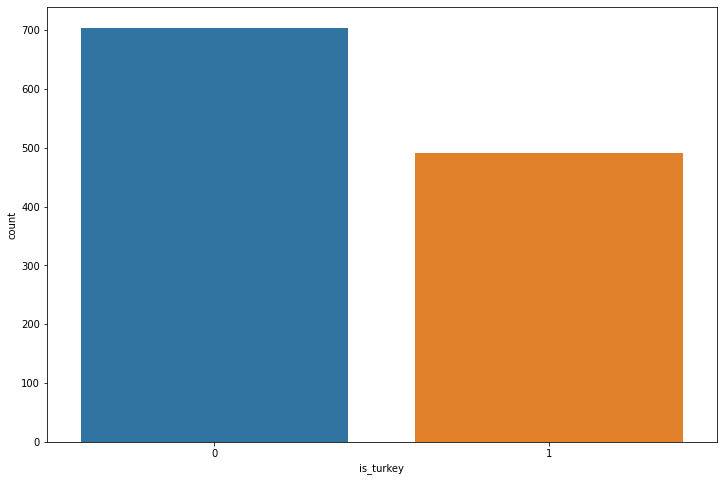

In [0]:
plt.figure(figsize=(12,8))
sns.countplot(train['is_turkey'])
plt.show()

In [0]:
test.head()

,audio_embedding,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[177, 20, 226, 132, 198, 81, 111, 59, 132, 18...",pyKh38FXD3E,10,0
1,"[[169, 21, 204, 161, 195, 72, 60, 39, 152, 184...",THhP1idrWXA,40,30
2,"[[165, 13, 198, 141, 199, 81, 173, 54, 119, 11...",jsw3T6GY2Nw,40,30
3,"[[167, 18, 188, 159, 198, 63, 156, 36, 179, 22...",nFkXTMHcjMU,24,14
4,"[[178, 32, 181, 100, 198, 46, 82, 83, 136, 227...",Au8g9kAlrLQ,40,30


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 5 columns):
audio_embedding                    1195 non-null object
is_turkey                          1195 non-null int64
vid_id                             1195 non-null object
end_time_seconds_youtube_clip      1195 non-null int64
start_time_seconds_youtube_clip    1195 non-null int64
dtypes: int64(3), object(2)
memory usage: 46.8+ KB


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 4 columns):
audio_embedding                    1196 non-null object
vid_id                             1196 non-null object
end_time_seconds_youtube_clip      1196 non-null int64
start_time_seconds_youtube_clip    1196 non-null int64
dtypes: int64(2), object(2)
memory usage: 37.5+ KB


In [0]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 2 columns):
vid_id       1196 non-null object
is_turkey    1196 non-null int64
dtypes: int64(1), object(1)
memory usage: 18.8+ KB


In [0]:
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

Using TensorFlow backend.


In [0]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
import keras
keras.__version__


Using TensorFlow backend.


'2.2.5'

In [0]:
train_train, train_val = train_test_split(train, random_state = 42)
xtrain = [k for k in train_train['audio_embedding']]
ytrain = train_train['is_turkey'].values

xval = [k for k in train_val['audio_embedding']]
yval = train_val['is_turkey'].values

x_train = pad_sequences(xtrain, maxlen=10)
x_val = pad_sequences(xval, maxlen=10)

y_train = np.asarray(ytrain)
y_val = np.asarray(yval)

In [0]:
print(x_train.shape)

(896, 10, 128)


In [0]:
print(x_train[0])

[[158  36 173 ...  16 255 255]
 [167  35 194 ... 144 235 255]
 [173  25 217 ...  94  69 255]
 ...
 [164  36 187 ...   0 240 255]
 [169  27 185 ...  74   0 255]
 [163  31 191 ... 107 189 255]]


In [0]:
print(ytrain.shape)

(896,)


In [0]:
print(yval)

[1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1
 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1
 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1
 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0
 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1
 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0
 1 0 0]


In [0]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints



max_len = 10
feature_size = 128
def build_model():
    inp = Input(shape=(max_len, feature_size))
    x = BatchNormalization()(inp)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(10)(x)
    concat = Dense(64, activation="relu")(x)
    concat = Dropout(0.5)(concat)
    output = Dense(1, activation="sigmoid")(concat)
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model
model = build_model()
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 128)           512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 256)           264192    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 128)           164864    
_________________________________________________________________
attention_1 (Attention)      (None, 128)               138       
__________________________________________

In [0]:
#fit on a portion of the training data, and validate on the rest
hist = model.fit(x_train, y_train, batch_size=300, epochs=100, validation_data=(x_val, y_val))




Train on 896 samples, validate on 299 samples
Epoch 1/100





896/896 [==============================] - 4s 5ms/step - loss: 0.6661 - acc: 0.6317 - val_loss: 0.6516 - val_acc: 0.6823
Epoch 2/100
896/896 [==============================] - 0s 70us/step - loss: 0.6336 - acc: 0.7277 - val_loss: 0.6246 - val_acc: 0.7759
Epoch 3/100
896/896 [==============================] - 0s 71us/step - loss: 0.6118 - acc: 0.7578 - val_loss: 0.5992 - val_acc: 0.8161
Epoch 4/100
896/896 [==============================] - 0s 71us/step - loss: 0.5800 - acc: 0.8092 - val_loss: 0.5745 - val_acc: 0.8462
Epoch 5/100
896/896 [==============================] - 0s 62us/step - loss: 0.5514 - acc: 0.8437 - val_loss: 0.5503 - val_acc: 0.8662
Epoch 6/100
896/896 [==============================] - 0s 59us/step - loss: 0.5280 - acc: 0.8683 - val_loss: 0.5264 - val_acc: 0.8729
Epoch 7/100
896/896 [==============================] - 0s 57us/step - loss: 0.4930 - acc: 0.9040 - val_loss: 0.5028 - val_acc: 0.8763
Epoch 8/1

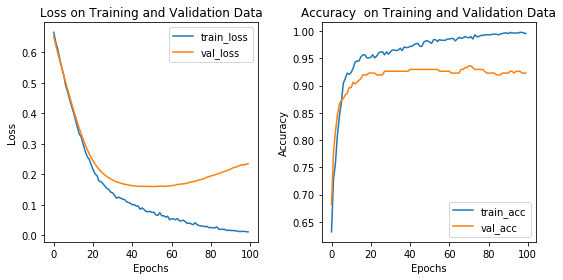

In [0]:
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()
training_vis(hist)

In [0]:
score, acc = model.evaluate(x_val, y_val, batch_size=256)
print('Test accuracy:', acc)

299/299 [==============================] - 0s 55us/step
Test accuracy: 0.9230769268645092


In [0]:
test_data = test['audio_embedding'].tolist()
submission = model.predict(pad_sequences(test_data))
submission = pd.DataFrame({'vid_id':test['vid_id'].values,'is_turkey':[x for y in submission for x in y]})
submission['is_turkey'] = submission.is_turkey
print(submission.head(40))
submission.to_csv('submission.csv', index=False)

         vid_id  is_turkey
0   pyKh38FXD3E   0.000100
1   THhP1idrWXA   0.000054
2   jsw3T6GY2Nw   0.000267
3   nFkXTMHcjMU   0.000094
4   Au8g9kAlrLQ   0.996087
5   tgk3DUpRI-w   0.000828
6   BczNwyCGlH4   0.000331
7   zB5eXpmJDTM   0.000052
8   099z8epFcfc   0.999464
9   lQ8DMnq415o   0.999626
10  GQiufwoajWs   0.999844
11  INo_-jgqN8k   0.999684
12  hYRPxAli0qQ   0.000094
13  3Gz_nevdXMw   0.917229
14  pRTdKKDW-eA   0.000075
15  Bea4YfWKAgY   0.000539
16  De-ZGbFCAes   0.999477
17  bWb7maOK2N4   0.001932
18  3yShrSi_g2I   0.000121
19  nUG2f3kzojI   0.998978
20  98MOYVfyKy4   0.000057
21  DntcoNVqEsQ   0.000239
22  t_acOLqB9ZA   0.000044
23  Di9E2EwpD_Y   0.998888
24  AMrMa379dY0   0.000089
25  phWfXmcDeRw   0.000101
26  AyACodY0hek   0.000085
27  U3YigFH5bMs   0.000153
28  sLHYvqfduwU   0.000477
29  xfGXhVboW9U   0.999439
30  GyjR5V0Sj94   0.000108
31  FcyOVSjbUEM   0.996875
32  NhKRCuCg0-g   0.999566
33  B_BlG6QhyCI   0.795306
34  CjPlMp0ToQc   0.736410
35  A5Ka8Yaonr8   0.000576
3

In [0]:
!pip install youtube_dl

     |████████████████████████████████| 1.8MB 4.9MB/s 


In [0]:
import youtube_dl 
import datetime
x = 1
url = 'https://www.youtube.com/watch?v=' + submission['vid_id'][x]
S = int(test['start_time_seconds_youtube_clip'][x])
E = int(test['end_time_seconds_youtube_clip'][x])
start_time = datetime.timedelta(seconds=30)
end_time = datetime.timedelta(seconds=40)
print(url)
ydl_opts = {
    'format': 'bestaudio/best', 
    'postprocessors': [{
        'key': 'FFmpegExtractAudio', 
        'preferredcodec': 'm4a' 
    }],
    'postprocessor_args': [
        "-ss","{st}".format(st=start_time),"-t","{et}".format(et=end_time) 
    ],
}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

https://www.youtube.com/watch?v=THhP1idrWXA
[youtube] THhP1idrWXA: Downloading webpage
[youtube] THhP1idrWXA: Downloading video info webpage
[download] Destination: Reaction to Skype laughter chain-THhP1idrWXA.m4a
[download] 100% of 1.01MiB in 00:00
[ffmpeg] Correcting container in "Reaction to Skype laughter chain-THhP1idrWXA.m4a"
[ffmpeg] Post-process file Reaction to Skype laughter chain-THhP1idrWXA.m4a exists, skipping
